# Preparation

In [2]:
!pip install -q google-play-scraper pandas numpy emoji wordcloud scikit-learn \
torch transformers datasets Sastrawi nltk langdetect evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import torch
import emoji
import seaborn as sns
import nltk
nltk.download('stopwords')
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Library untuk IndoBERT dan NLP
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Scrapping Data

In [4]:
from google_play_scraper import reviews_all, Sort

def get_reviews(app_id, count=10000):
    result = reviews_all(app_id, lang='id', country='id', sort=Sort.NEWEST)
    if len(result) > count: result = result[:count]
    return pd.DataFrame(result)

app_id = 'com.pegadaiandigital'
df = get_reviews(app_id)
print("Jumlah ulasan:", len(df))
df.to_csv("pegadaian_reviews.csv", index=False)

Jumlah ulasan: 10000


# Cleaning Data

In [5]:
df = pd.read_csv("pegadaian_reviews.csv")
print("Jumlah awal data:", len(df))

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s.,!?]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_review"] = df["content"].apply(clean_text)

df.drop_duplicates(subset=["cleaned_review"], inplace=True)
df = df[df["cleaned_review"].str.strip() != ""]

print("Jumlah setelah cleaning:", len(df))

print("\nContoh hasil cleaning:")
for i in range(min(5, len(df))):
    print(f"Sebelum : {df.iloc[i]['content']}")
    print(f"Sesudah : {df.iloc[i]['cleaned_review']}")
    print("-" * 40)

df.to_csv("pegadaian_reviews_cleaned.csv", index=False)
print("\nCleaning selesai → disimpan ke: pegadaian_reviews_cleaned.csv")

Jumlah awal data: 10000
Jumlah setelah cleaning: 8482

Contoh hasil cleaning:
Sebelum : baik sukses selalu ya
Sesudah : baik sukses selalu ya
----------------------------------------
Sebelum : Aplikasi paling busuk yg ada dihandphone saya!
Sesudah : aplikasi paling busuk yg ada dihandphone saya!
----------------------------------------
Sebelum : aplikasi sampah, sering ngefreeze, tidak bisa log-in
Sesudah : aplikasi sampah, sering ngefreeze, tidak bisa log in
----------------------------------------
Sebelum : apk nya bagus banget, pokoknya dijamin ramah dah
Sesudah : apk nya bagus banget, pokoknya dijamin ramah dah
----------------------------------------
Sebelum : aplikasi apaan ini, sampang banget sumpah, tiba2 logout sendiri, login lagi gak bisa
Sesudah : aplikasi apaan ini, sampang banget sumpah, tiba2 logout sendiri, login lagi gak bisa
----------------------------------------

Cleaning selesai → disimpan ke: pegadaian_reviews_cleaned.csv


# Labeling

Distribusi label sentimen:
label
negative    4506
positive    3458
neutral      518
Name: count, dtype: int64


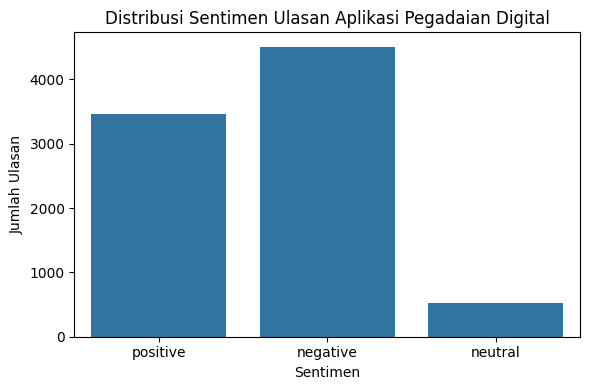


Labeling selesai → disimpan ke: pegadaian_reviews_labeled.csv


In [6]:
# Load hasil cleaning
df = pd.read_csv("pegadaian_reviews_cleaned.csv")

# Pastikan kolom 'score' ada dan valid
if "score" not in df.columns:
    raise ValueError("Kolom 'score' tidak ditemukan di dataset. Pastikan hasil scraping memiliki rating.")

# Hapus baris dengan score kosong atau tidak valid
df = df.dropna(subset=["score"])
df = df[df["score"].astype(str).str.isnumeric()]
df["score"] = df["score"].astype(int)

# Labeling sentimen berdasarkan rating
def label_sentiment(score):
    if score >= 4:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"

df["label"] = df["score"].apply(label_sentiment)

# Encode label -> angka
label2id = {"negative": 0, "neutral": 1, "positive": 2}
df["label_id"] = df["label"].map(label2id)

# Cek distribusi label
print("Distribusi label sentimen:")
print(df["label"].value_counts())

# Visualisasi (lebih rapi)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Distribusi Sentimen Ulasan Aplikasi Pegadaian Digital")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.tight_layout()
plt.show()

# Simpan hasil final
df.to_csv("pegadaian_reviews_labeled.csv", index=False)
print("\nLabeling selesai → disimpan ke: pegadaian_reviews_labeled.csv")

# Tokenisasi

In [7]:
import warnings

warnings.filterwarnings("ignore")

# Load data labeled
df = pd.read_csv("pegadaian_reviews_labeled.csv")
df = df[["cleaned_review", "label_id"]].dropna()
df = df[df["cleaned_review"].str.strip() != ""]
print("Total data:", len(df))

# Split data
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

print("Train:", len(train_df))
print("Test :", len(test_df))

# Load tokenizer
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["cleaned_review"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Convert to HF dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

# Torch format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("\nContoh token:")
print(train_dataset[0])

Total data: 8482
Train: 6785
Test : 1697


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6785 [00:00<?, ? examples/s]

Map:   0%|          | 0/1697 [00:00<?, ? examples/s]


Contoh token:
{'labels': tensor(2), 'input_ids': tensor([    2, 12700,   815, 10698,  5562,  4398,    43, 19463, 30365,   286,
        30468,   387,  4587,    50,  7356,  1080, 10626, 22324,   286, 14891,
        20972,  4017,    57, 30477,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,

In [8]:
from transformers import AutoTokenizer
import torch

# Konsisten dengan kode sebelumnya
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fungsi tokenisasi untuk inference
def tokenize_texts(texts, max_len=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# Tokenisasi seluruh review
texts = df["cleaned_review"].tolist()
tokens = tokenize_texts(texts)

print(tokens)

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

{'input_ids': tensor([[  760,  2452,   947,  ...,     1,     1,     1],
        [11650,   875, 17009,  ...,     1,     1,     1],
        [11650,  4163,    16,  ...,     1,     1,     1],
        ...,
        [26747,  1373,  2908,  ...,     1,     1,     1],
        [49235,  2141,    16,  ...,     1,     1,     1],
        [14061,  1076,   700,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


# Sentiment Analysis (IndoBert)

In [9]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments
)
from transformers import Trainer
import numpy as np
import evaluate
import torch
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute class weights
train_labels = np.array([item["labels"] for item in train_dataset])
classes = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=classes, y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Custom Trainer with Focal Loss
class WeightedFocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Focal loss
        ce_loss = F.cross_entropy(logits, labels, reduction="none", weight=class_weights)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** 2 * ce_loss).mean()  # gamma=2
        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir="./fast_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32 if device == "cuda" else 16,
    per_device_eval_batch_size=32 if device == "cuda" else 16,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    weight_decay=0.01,
    logging_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True
)

# Initialize Trainer
trainer = WeightedFocalTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate model
print(trainer.evaluate())

# Save model & tokenizer
trainer.save_model("roberta_super_fast")
tokenizer.save_pretrained("roberta_super_fast")

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohammadyahya2113 (mohammadyahya2113-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.403399,0.414850,0.381119
2,No log,0.457881,0.641721,0.553514
3,0.423700,0.466097,0.629935,0.552687


{'eval_loss': 0.45788100361824036, 'eval_accuracy': 0.6417206835592222, 'eval_f1_macro': 0.5535138606800817, 'eval_runtime': 2.9636, 'eval_samples_per_second': 572.605, 'eval_steps_per_second': 18.221, 'epoch': 3.0}


('roberta_super_fast/tokenizer_config.json',
 'roberta_super_fast/special_tokens_map.json',
 'roberta_super_fast/vocab.json',
 'roberta_super_fast/merges.txt',
 'roberta_super_fast/added_tokens.json',
 'roberta_super_fast/tokenizer.json')

# Evaluasi Model

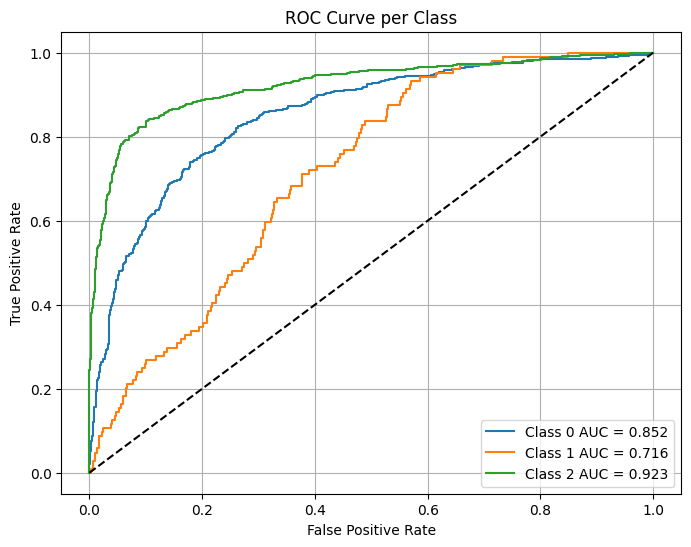

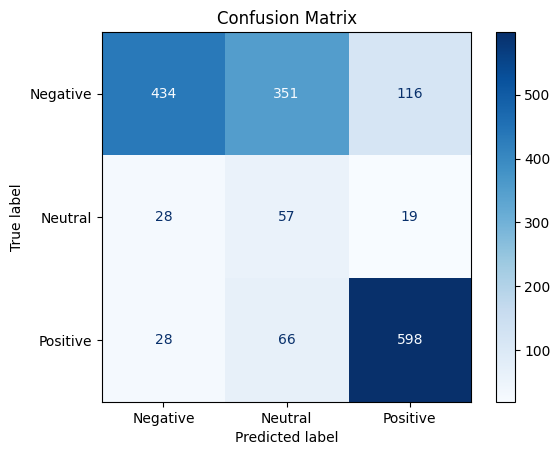

In [10]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_labels = []
all_probs = []

# Ambil prediksi probabilities
with torch.no_grad():
    for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].numpy()

        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        all_labels.extend(labels)
        all_probs.extend(probs)

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ROC CURVE (MULTICLASS)
classes = [0, 1, 2]
y_bin = label_binarize(all_labels, classes=classes)

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} AUC = {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend()
plt.grid(True)
plt.show()

# CONFUSION MATRIX
y_pred = np.argmax(all_probs, axis=1)
cm = confusion_matrix(all_labels, y_pred, labels=classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Neutral", "Positive"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Visualisasi WordCloud

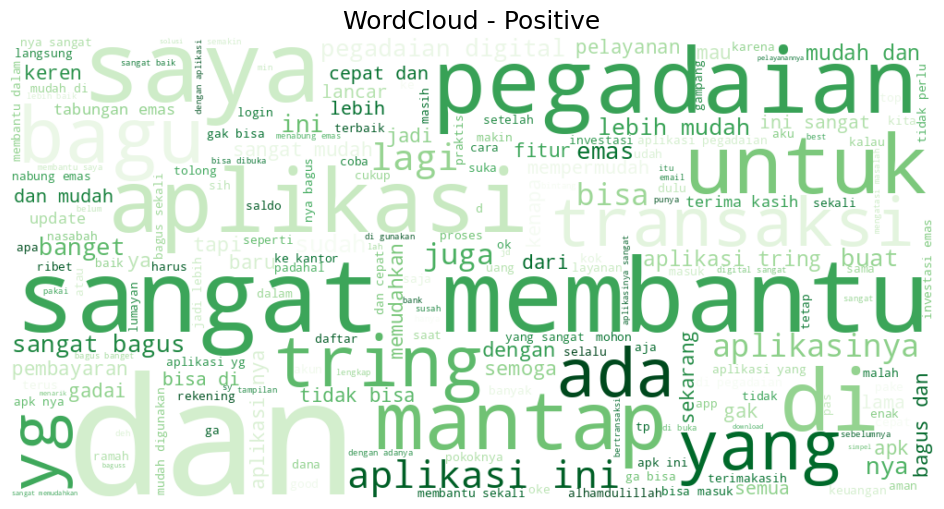

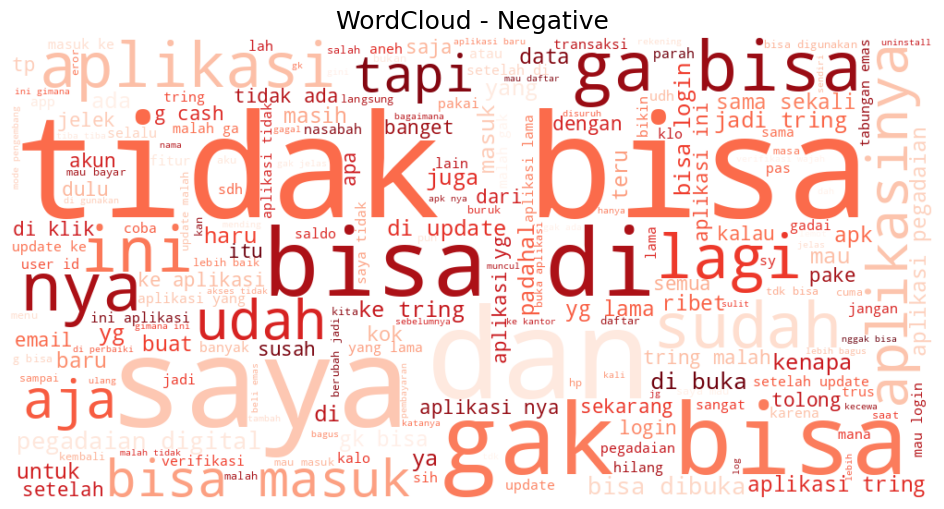

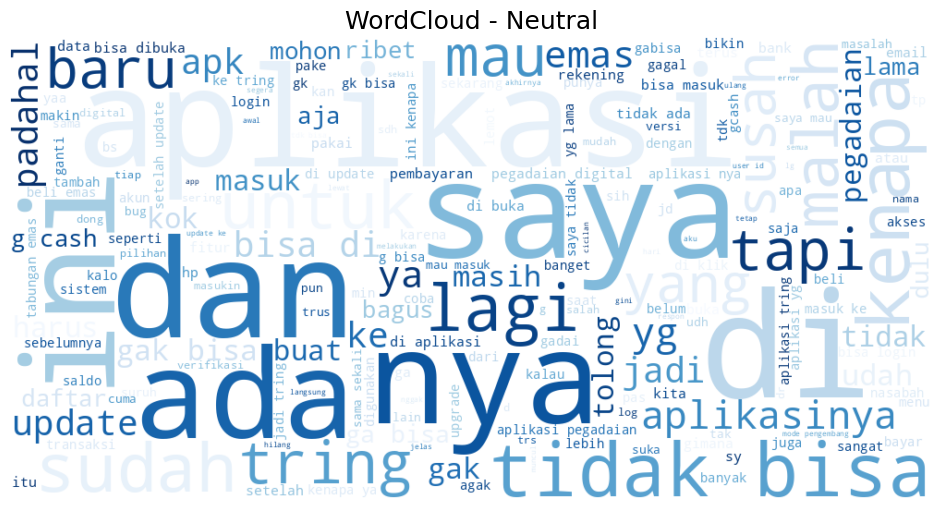

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan dataset yang sudah di-label dimuat
df = pd.read_csv("pegadaian_reviews_labeled.csv")

# Pastikan kolomnya sesuai
df["cleaned_review"] = df["cleaned_review"].astype(str)
df["label"] = df["label"].astype(str)

def plot_wordcloud(sentiment, colormap):
    subset = df[df["label"] == sentiment]
    text = " ".join(subset["cleaned_review"].tolist())

    if len(text.strip()) == 0:
        print(f"Tidak ada kata untuk sentimen {sentiment}")
        return

    wc = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        colormap=colormap,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment.capitalize()}", fontsize=18)
    plt.show()

# Generate wordcloud untuk masing-masing sentimen
plot_wordcloud("positive", "Greens")
plot_wordcloud("negative", "Reds")
plot_wordcloud("neutral", "Blues")

# Interpretasi & Insight

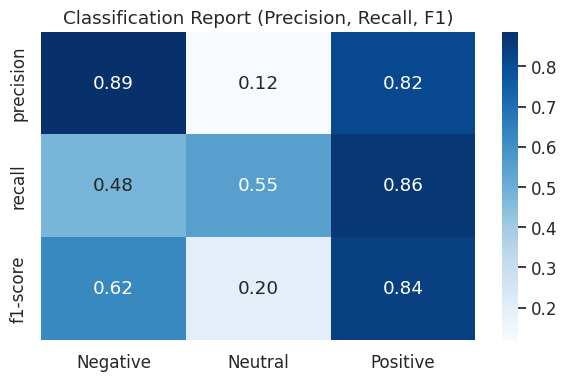

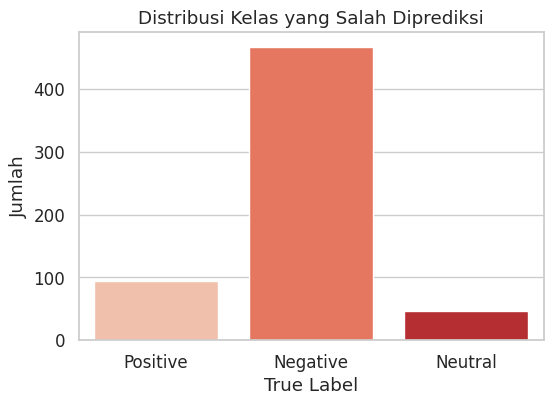

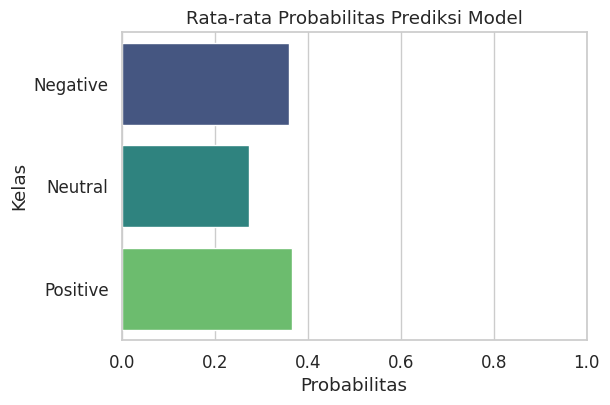

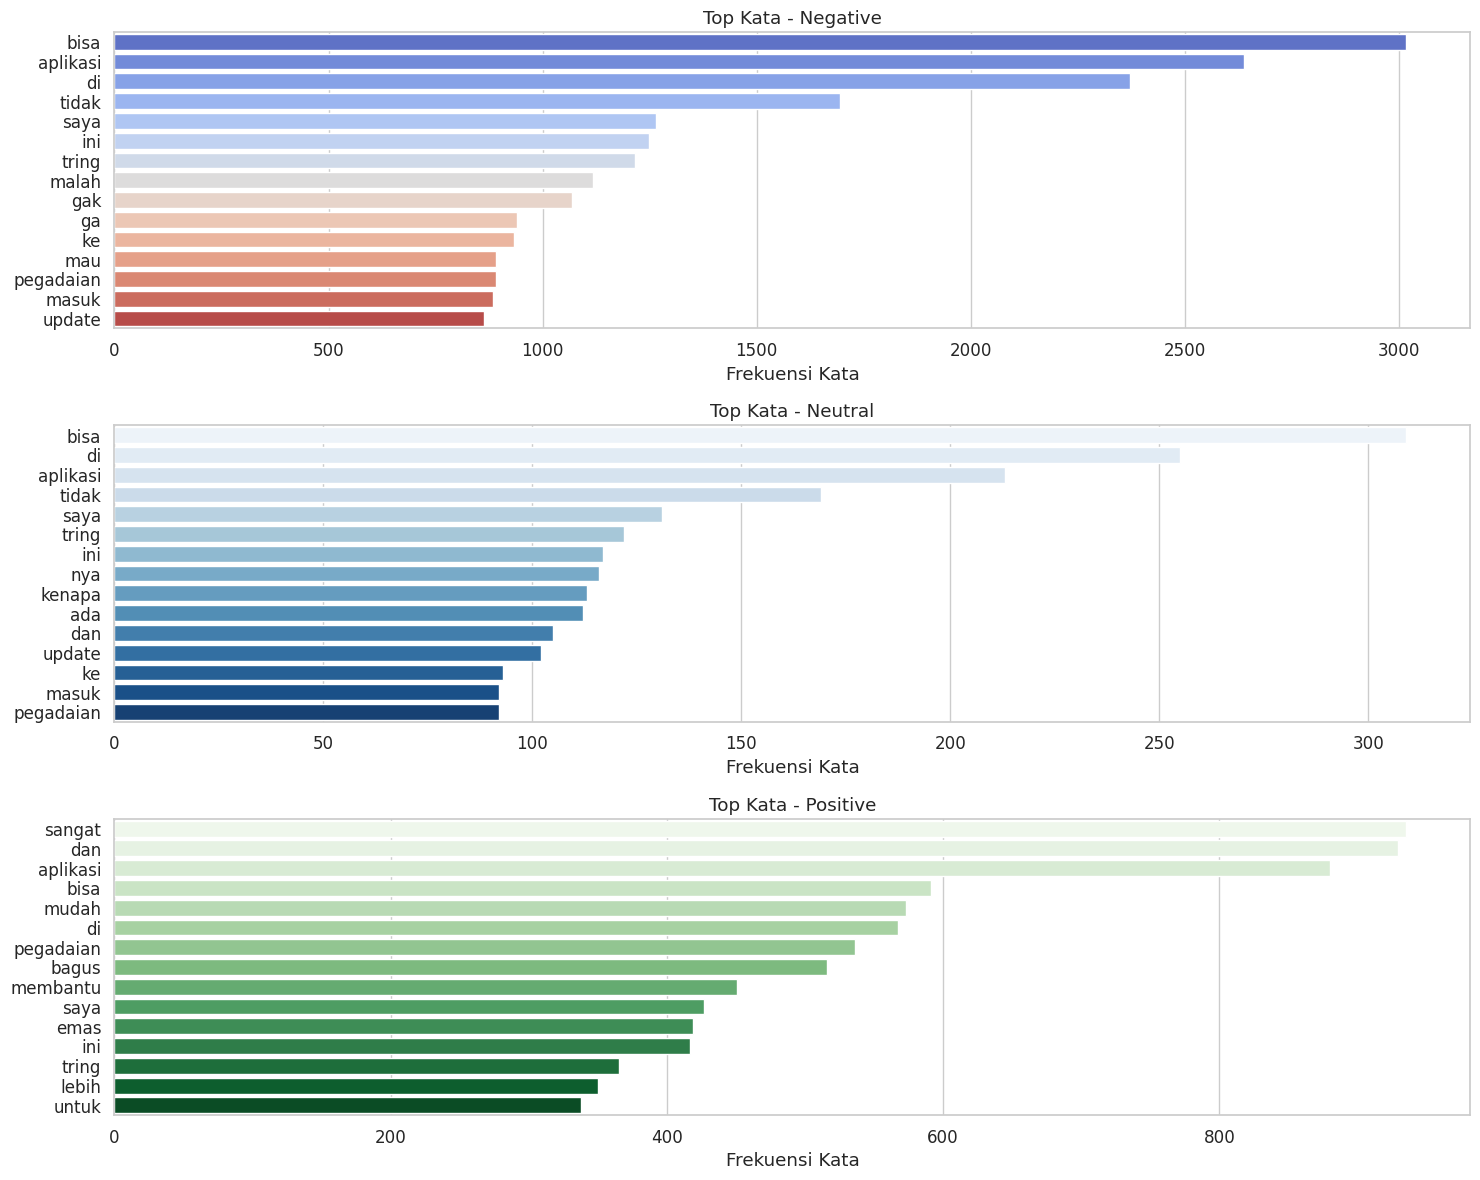

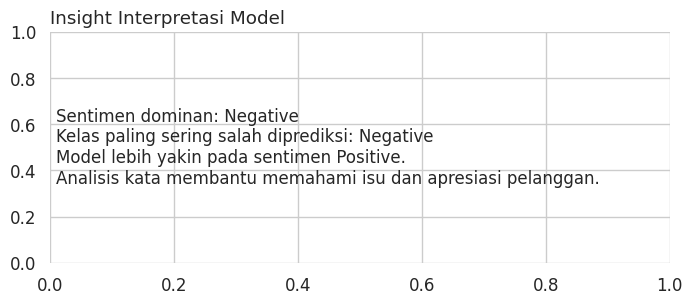

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
import re
import collections

# STYLE
sns.set(style="whitegrid", font_scale=1.1)

# Classification Report (Heatmap)
report = classification_report(
    all_labels,
    y_pred,
    target_names=["Negative", "Neutral", "Positive"],
    output_dict=True
)
df_cr = pd.DataFrame(report).iloc[:-1, :3]  # remove accuracy & avg

plt.figure(figsize=(7, 4))
sns.heatmap(df_cr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report (Precision, Recall, F1)")
plt.show()

# Grafik Jumlah Prediksi Salah
df_test = pd.DataFrame({
    "review": test_df["cleaned_review"].values,
    "true": all_labels,
    "pred": y_pred
})
wrong = df_test[df_test["true"] != df_test["pred"]]

plt.figure(figsize=(6, 4))
sns.countplot(x=wrong["true"].map({0: "Negative", 1: "Neutral", 2: "Positive"}), palette="Reds")
plt.title("Distribusi Kelas yang Salah Diprediksi")
plt.xlabel("True Label")
plt.ylabel("Jumlah")
plt.show()

# Probabilitas Rata-rata Model
avg_probs = pd.DataFrame(all_probs, columns=["Negative", "Neutral", "Positive"]).mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=avg_probs.values, y=avg_probs.index, palette="viridis")
plt.title("Rata-rata Probabilitas Prediksi Model")
plt.xlabel("Probabilitas")
plt.ylabel("Kelas")
plt.xlim(0, 1)
plt.show()

# Top Kata per Sentimen (Bar Chart)
def get_top_words(text_data, n=15):
    words = " ".join(text_data).lower()
    words = re.findall(r"\b[a-zA-Z]+\b", words)
    counter = collections.Counter(words)
    return counter.most_common(n)

sentiments = {
    "Negative": df[df["label"] == "negative"]["cleaned_review"],
    "Neutral": df[df["label"] == "neutral"]["cleaned_review"],
    "Positive": df[df["label"] == "positive"]["cleaned_review"],
}

plt.figure(figsize=(15, 12))

for i, (label, data) in enumerate(sentiments.items(), 1):
    top_words = get_top_words(data)
    words, counts = zip(*top_words)

    plt.subplot(3, 1, i)
    sns.barplot(x=list(counts), y=list(words), palette="coolwarm" if label == "Negative"
                else "Blues" if label == "Neutral" else "Greens")
    plt.title(f"Top Kata - {label}")
    plt.xlabel("Frekuensi Kata")

plt.tight_layout()
plt.show()

# Insight Otomatis (Ditampilkan seperti card)
dominant_sentiment = df["label"].value_counts().idxmax()
hard_class = wrong["true"].value_counts().idxmax()

bias = ""
if avg_probs["Neutral"] > 0.5:
    bias = "Model cenderung bias ke sentimen Neutral."
elif avg_probs["Positive"] > avg_probs["Negative"]:
    bias = "Model lebih yakin pada sentimen Positive."
else:
    bias = "Model lebih yakin pada sentimen Negative."

plt.figure(figsize=(8, 3))
plt.text(0.01, 0.5,
         f"Sentimen dominan: {dominant_sentiment.capitalize()}\n"
         f"Kelas paling sering salah diprediksi: {['Negative','Neutral','Positive'][hard_class]}\n"
         f"{bias}\n"
         "Analisis kata membantu memahami isu dan apresiasi pelanggan.",
         fontsize=12, va="center")
plt.box(False)
plt.title("Insight Interpretasi Model", loc="left")
plt.show()
